## Energy minimization for a 2D sheet in 3D

In [1]:
#import tyssue
import sys
#sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue import config
import tyssue.dynamics.sheet_isotropic_model as iso
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io import hdf5


In [2]:
h5store = '../examples/small_hexagonal.hf5'
#h5store = '../examples/before_apoptosis.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)
sheet.vert_df.describe().head(3)


,y,is_active,z,x,rho,old_idx,basal_shift,height,radial_tension
count,9.600000e+01,96.0,9.600000e+01,9.600000e+01,9.600000e+01,96.000000,9.600000e+01,9.600000e+01,96.0
mean,1.036208e-15,1.0,2.232717e-10,-3.053113e-15,8.071439e+00,103.500000,2.216510e+00,5.854929e+00,0.0
std,5.737329e+00,0.0,9.469935e+00,5.737329e+00,5.905587e-15,27.856777,4.464204e-16,5.905587e-15,0.0


we define the adimensional contractility $\bar\Gamma = \Gamma/K_vV_0^{4/3}$ and line tension
$\bar\Lambda = \Lambda /K_vV_0^{5/3}$.

In [3]:
sheet.face_df.describe().head(3)

,area,z,y,is_alive,x,perimeter,old_idx,num_sides,vol,prefered_area,prefered_vol,contractility,vol_elasticity,prefered_height,basal_shift,basal_height,height,rho
count,56.000000,5.600000e+01,5.600000e+01,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.0,56.0,5.600000e+01,56.0,56.0,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01
mean,25.335875,2.551683e-10,1.015061e-15,0.714286,-2.918301e-15,17.716800,27.500000,4.857143,148.339751,12.0,288.0,7.607640e+01,1.0,24.0,2.500032e+00,-3.246161e+00,5.854929e+00,8.071439e+00
std,14.266233,9.931764e+00,5.519262e+00,0.455842,5.519262e+00,6.657482,16.309506,1.823369,83.527781,0.0,0.0,1.433946e-14,0.0,0.0,4.481082e-16,4.481082e-16,3.186658e-15,3.086050e-15


In [4]:
sheet.edge_df.describe().head(3)

,dz,length,dx,dy,srce,trgt,face,old_jv0,old_jv1,old_cell,...,nx,ny,sub_area,sub_vol,line_tension,is_alive,ux,uy,uz,is_active
count,2.720000e+02,272.000000,2.720000e+02,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,...,2.720000e+02,2.720000e+02,272.000000,272.000000,2.720000e+02,272.000000,272.0,272.0,272.0,272.000000
mean,-1.306145e-17,3.647576,1.306145e-17,8.163405e-18,47.477941,47.477941,27.500000,99.602941,107.352941,27.500000,...,4.901347e-10,-4.901341e-10,5.216210,30.540537,1.507193e+03,0.882353,0.0,0.0,0.0,0.882353
std,2.515362e+00,0.008030,1.874423e+00,1.874423e+00,27.725318,27.725318,16.156522,27.179947,27.721741,16.156522,...,7.634225e+00,7.634225e+00,1.456322,8.526663,2.277928e-13,0.322784,0.0,0.0,0.0,0.322784


## Non dimensionalisation

For our 2D1/2 model, for a tissue energy is expressed as:
$$
E = N_f\frac{K}{2}(V - V_0)^2 + N_f \frac{\Gamma}{2}L^2 + 3N_f\Lambda \ell 
$$
In the case of a regular, infinite hexagonal lattice, There 6 edges per cell, each shared bteween 2 cells, hence $Ne = 3N_f$

We can write this equation as a dimension-less one by dividing it by $N_f K V_0^2$. We define the dimension-less values: $\bar\Gamma = \Gamma/K V_0^{4/3}$ and $\bar\Lambda = \Lambda/K V_0^{5/3}$

$$
\bar{E} = \frac{\left(V/V_0 - 1\right)^2}{2} + \bar\Gamma \frac{V_0^{-2/3}}{2}L^2 + 3\bar\Lambda V_0^{-1/3} \ell
$$

We define the scaling factor $\delta$ such that $V/V_0 = \delta^3$. On a regular hexagonal grid, the perimeter $L=6\ell$ and the area is A=$3\sqrt{3}/2\,\ell^2$. The volume is $V = Ah$. As the (pseudo-)height is arbitrary, we can chose its prefered value. We set $h_0 = V_0^{1/3}$.

We thus have $A_0 = V_0^{2/3}$, $A = \delta^2 V_0^{2/3}$ and 
$\ell = \delta (\frac{2}{3\sqrt{3}})^{1/2} V_0^{1/3}$. We define the constant $\mu = 2^{3/2}3^{1/4}$ to simplify further the equation:

$$
\begin{eqnarray}
\bar{E} &=& \frac{(\delta^3 - 1)^2}{2} + \frac{12}{\sqrt{3}}\bar\Gamma\delta^2 + \frac{6}{\sqrt{3}}\bar\Lambda \delta \\
\bar{E} &=& \frac{(\delta^3 - 1)^2}{2} + \frac{\mu^2}{2}\bar\Gamma\delta^2 + \frac{\mu}{2}\bar\Lambda \delta \\
\end{eqnarray}
$$


The root of this polynomial corresponds to the lowest energy possible for this set of paramters.






In [5]:
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)

sheet.update_specs(dim_model_specs, reset=True)
sheet.edge_df.is_active = (sheet.upcast_face(sheet.face_df.is_alive)
                           & sheet.upcast_srce(sheet.vert_df.is_active))
isotropic_relax(sheet, nondim_specs)

Reseting datasets values with new specs


In [6]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 18.583011590208525


0.886592687387 0.897959183673


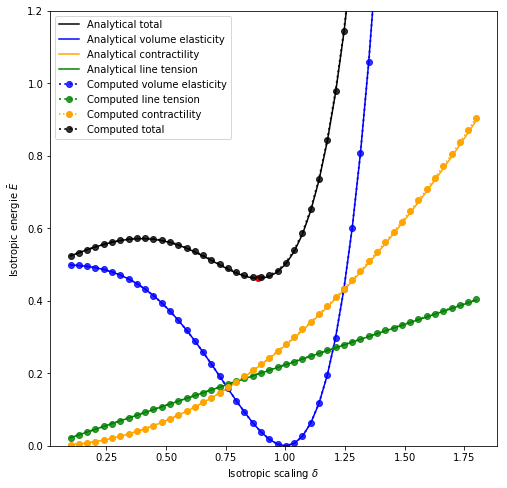

In [7]:
from tyssue.draw.plt_draw import plot_analytical_to_numeric_comp
fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom,
                                          iso, nondim_specs)


In [10]:
nondim_specs

{'edge': {'is_active': 1,
  'line_tension': 0.12,
  'ux': 0.0,
  'uy': 0.0,
  'uz': 0.0},
 'face': {'contractility': 0.04,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 288.0,
  'vol_elasticity': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 1.0},
 'vert': {'is_active': 1, 'radial_tension': 0.0}}

In [8]:
dim_model_specs

{'edge': {'is_active': 1,
  'line_tension': 1507.1925045186904,
  'ux': 0.0,
  'uy': 0.0,
  'uz': 0.0},
 'face': {'contractility': 76.076403814532171,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 288.0,
  'vol_elasticity': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 82944.0},
 'vert': {'is_active': 1, 'radial_tension': 0.0}}

In [8]:
model.compute_energy(sheet) / sheet.face_df.is_alive.sum()

0.46457760914049684

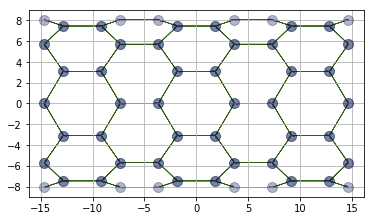

In [9]:
isotropic_relax(sheet, nondim_specs)

fig, ax = sheet_view(sheet, ['z', 'x'])

In [10]:
model.labels

['Line tension', 'Contractility', 'Volume elasticity']

In [11]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

,gx,gy,gz
edge,,,
0,-0.000000,0.000000,0.000000
1,-0.000000,0.000000,-0.000000
2,127.116863,-639.059628,-378.617758
3,-127.116863,-639.059628,378.617758
4,-0.000000,-0.000000,-753.596252


In [12]:
grad_i = model.compute_gradient(sheet, components=False)
grad_i.head()

,gx,gy,gz
srce,,,
0,0.000228,1.096517e-17,-0.010386
1,-0.010778,-4.464475e-03,-0.009618
2,0.000161,1.614982e-04,-0.010386
3,-0.010778,4.464475e-03,-0.009618
4,-0.010567,4.377072e-03,-0.000769


In [13]:
geom.scale(sheet, 2, sheet.coords)
geom.update_all(sheet)

In [14]:
bck_lt = sheet.edge_df.line_tension.copy()
bck_ct = sheet.face_df.contractility.copy()
bck_ve = sheet.face_df.vol_elasticity.copy()


In [15]:
# sheet.edge_df.line_tension = 0
# sheet.face_df.vol_elasticity = 0
# sheet.face_df.contractility = 0

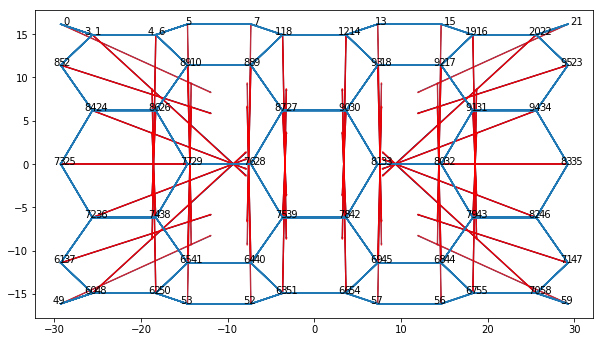

In [16]:
scale = 5
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})
    
def draw_approx_force(ax=None):
    fig, ax = draw.plot_forces(sheet, geom, model,
                              ['z', 'x'], scaling=scale, ax=ax,
                              approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

In [17]:
sheet.coords

['x', 'y', 'z']

In [18]:
sheet.edge_df.line_tension = bck_lt.copy()
sheet.face_df.contractility = bck_ct.copy()
sheet.face_df.vol_elasticity = bck_ve.copy()

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [19]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


Error on the gradient (non-dim, per vertex): 9.991e-05


In [20]:
settings = {
    'minimize': {
        'options': {'disp':False,
                    'ftol':1e-5,
                    'gtol':1e-5},
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [21]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [22]:
res['fun']/sheet.face_df.is_alive.sum()

0.45102508181702594

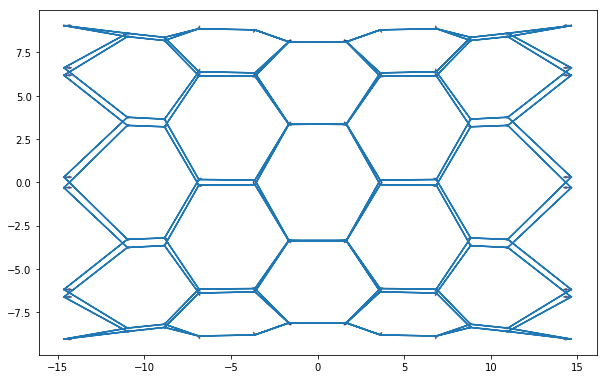

In [23]:
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'y'], 10)
fig.set_size_inches(10, 12)
